# 1. 학습이란?

- 훈련 데이터로부터 가중치 최적값을 자동으로 획득하는 것
- Neural network가 학습할 수 있도록 손실 함수를 사용한다. -> 손실 함수가 가장 작게 되는것이 최적값이다.

# 2. 훈련 데이터와 시험 데이터

- 기계학습에서는 보통 학습 데이터와 시험 데이터를 나누어서 사용한다.
- 둘을 나누어서 사용하는 이유는 학습한 가중치값이 다른 예에서도 제대로 작동하는지 확인하는것이다.

# 3. 손실 함수

- 하나의 지표로서 얼마나 학습 데이터에 학습이 잘 되었는지 판단한다.
- 일반적으로는 평균 제곱 오차(MSE), 교차 엔트로피 오차를 사용한다.

## 3.1. 평균 제곱 오차(Mean Squared Error)
- MSE의 수식
$$
E = \frac{1}{2}\sum_k(y_k - t_k)^2
$$
여기서 y<sub>k</sub>는 신경망의 출력, t<sub>k</sub>는 정답 레이블, k는 데이터의 차원수를 나타낸다.

- MSE는 신경망의 출력과 정답 레이블이 얼마나 다른지를 판별한다고 할 수 있다.

In [1]:
import numpy as np

# MSE의 구현
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [2]:
# 정답 레이블과 출력값을 정해놓고 MSE를 사용해보기
# 정답 레이블은 원한 인코딩을 사용

# 정답 레이블
t = np.array([0, 0 ,1 ,0, 0, 0, 0, 0, 0, 0]) 

# 첫번째 출력 값(소프트 맥스를 사용한 값)
y = np.array([0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0])
print("첫 번째 출력 값에 대한 손실 함수 값: {:1.2}".format(mean_squared_error(y, t)))

# 두번째 출력 값
y = np.array([0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0])
print("두 번째 출력 값에 대한 손실 함수 값: {}".format(mean_squared_error(y, t)))

첫 번째 출력 값에 대한 손실 함수 값: 0.098
두 번째 출력 값에 대한 손실 함수 값: 0.5975


위의 결과를 보아 출력 값과 정답 레이블이 비슷할 수록 손실 함수값이 작아지는것을 확인할 수 있다.

## 3.2. 교차 엔트로피 오차(Cross Entropy Error)
- CEE의 수식
$$
E = -\sum_k t_klogy_k
$$
t<sub>k</sub>는 정답일 때만 1이고 나머지는 0이기에, 정답일 떄의 자연로그 값을 계산하는 식이다.


![logx_그래프](./images/logx.png)

logx의 그래프를 보면 -logx의 값이 1에 가까워질 수록, 0에 가까워지고 0에 가까울 수록 값이 커진다는것을 알 수 있다.
따라서 출력값이 1에 가까워질 수록 최적화가 된다는것을 알 수 있다.

In [3]:
# CEE 구현
def cross_entropy_error(y,t):
    # log0은 무한대이기 때문에 아주 작은 값인 delta값을 설정한다.
    delta = 1e-7
    return -np.sum(t*np.log(y + delta))

# 4. 미니배치 학습

- 작은 데이터 집합(미니 배치)들을 여러개로 하여서 훈련을 하는 것
- 미니 배치로 CEE를 적용한 수식
$$
E = - \frac{1}{N} \sum_n \sum_k t_{nk}logy_{nk}
$$

- n개의 데이터를 가지고 손실함수 값을 구하여 평균을 낸다.

## 4.1. mnist 데이터를 미니배치로 학습

- 60,000개의 데이터에서 100장을 뽑아서 미니배치를 만들어 학습

In [4]:
# mnist 학습 데이터를 1차원으로 변환 및 label을 one_hot으로 변환

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data()

# 훈련데이터의 28*28을 784로 바꾸어주는 함수
def trans_flatten(train):
    train = train.reshape(train.shape[0], train.shape[1]*train.shape[2])
    
    return train

# 라벨을 one_hot 인코딩을 바꾸어주는 함수
def trans_one_hot(labels):
    one_labels = []
    
    for label in labels:
        one_hot = [0,0,0,0,0,0,0,0,0,0]
        one_hot[label] = 1
    
        one_labels.append(one_hot)
        
    one_labels = np.array(one_labels)
        
    return one_labels

x_train = trans_flatten(x_train)
x_test = trans_flatten(x_test)

t_train = trans_one_hot(t_train)
t_test = trans_one_hot(t_test)

In [5]:
# 배치 데이터 생성
train_size = x_train.shape[0]
batch_size = 10

# np.random.choice는 첫 번째 인자까지의 숫자 사이에서 두 번째 인자의 개수만큼 무작위로 index를 정한다.
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

## 4.2 (배치용) 교차 엔트로피 오차 구현

In [6]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

## 4.3. 손실 함수를 설정하는 이유?

- 학습을 할 때 미분을 이용하여 값을 변화시킨다.
- 정확도를 지표로 학습을하게 되면 대부분의 장소에서 0이 되기 때문에 정확도를 지표로 삼을 수 없다.

# 5. 수치 미분

## 5.1. 미분

- 미분은 한순간의 변화량을 표시한 것
- 수식
$$
\frac{df(x)}{dx} = \lim_{h\rightarrow 0} \frac{f(x+h) - f(x)}{h}
$$

In [7]:
# 미분의 구현 예 1
# 수치 미분
def numerical_diff(f, x):
    h = 10e-50
    return (f(x+h) - f(x)) / h

하지만 위의 방법은 반올림 오차 문제를 일으킨다.(h로 너무 작은 값을 사용하였기 때문에)

In [8]:
# 반올림 오차의 예
# 본래는 1e-50을 출력해야하지만 반올림 오차로 0을 출력한다.
np.float32(1e-50)

0.0

In [9]:
# 수치 미분에는 오차가 포함된다.
# 중심 차분의 구현
def numerical_diff(f,x):
    # 보통 1e-4 정도면 좋은 결과를 얻는다고 알려져있다.
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

In [10]:
# 수치 미분 예
def function_1(x):
    return 0.01*x**2 + 0.1*x

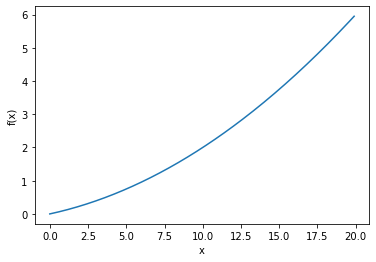

In [11]:
import matplotlib.pylab as plt

x = np.arange(0.0, 20.0 , 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [12]:
numerical_diff(function_1, 5)

0.1999999999990898

In [13]:
numerical_diff(function_1, 10)

0.2999999999986347

## 5.2. 편미분

- 변수가 두개인 함수의 미분

$$
f(x_0, x_1) = x^2_0 + x^2_1
$$

In [14]:
def function_2(x):
    return x[0]**2 + x[1]**2

x<sub>0</sub> = 3, x<sub>1</sub> = 4 일때 x<sub>0</sub>에 대한 x<sub>0</sub>에 대한 편미분

In [15]:
def function_tmp1(x0):
    return x0*x0 + 4.0**2.0

numerical_diff(function_tmp1, 3.0)

6.00000000000378

x<sub>0</sub> = 3, x<sub>1</sub> = 4 일때 x<sub>0</sub>에 대한 x<sub>1</sub>에 대한 편미분

In [16]:
def function_tmp2(x1):
    return 3.0**2.0 + x1*x1

numerical_diff(function_tmp2, 4.0)

7.999999999999119

## 5.3. 기울기(gradient)

- 편미분에서 모든 변수의 편미분을 벡터로 정리한 것

In [17]:
def numerical_gradient(f,x):
    h = 1e-4
    grad = np.zeros_like(x) # x와 모양이 같지만 내용은 모두 0인 배열을 생성
    
    for idx in range(x.size):
        # idx 번째의 편미분
        tmp_val = x[idx]
        
        # x+h 계산
        x[idx] = tmp_val + h 
        fxh1 = f(x)
        
        # x-h 계산
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값을 복원
        
    return grad

In [18]:
# fucntion_2의 (3,4), (0,2), (3,0)에서의 기울기 계산
print(numerical_gradient(function_2, np.array([3.0, 4.0])))
print(numerical_gradient(function_2, np.array([0.0, 2.0])))
print(numerical_gradient(function_2, np.array([3.0, 0.0])))

[6. 8.]
[0. 4.]
[6. 0.]


기울기는 각 지점에서 낮아지는 방향을 가리키는 것으로 함수의 출력 값을 가장 크게 줄이는 방법이다.

따라서 손실 함수는 기울기를 가지고서 최소값으로 향할 수 있다.

### 5.3.1. 경사법(경사 하강법)

- 기울기를 이용하여 함수의 최솟값을 찾으려는 방법
- 기울기 방향으로 일정 보폭을 움직이게하여 적절한 가중치의 값을 찾는다.


- 경사법 수식


$$
x_0 = x_0 - \eta \frac{\delta f}{\delta x_0}
$$


$$
x_1 = x_1 - \eta \frac{\delta f}{\delta x_1}
$$


- 여기서 η 기호는 학습률을 나타낸다.
- 학습률은 0.01이나 0.001 등 미리 특정 값으로 정해 둔다.


In [19]:
# 경사 하강법 구현
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x) # 기울기를 구함
        x -= lr * grad # 원본에서 학습률 * 기울기 만큼 이동함
        
    return x

In [20]:
# 경사 하강법으로 function_2의 최솟값을 구하기
init_x = np.array([-3.0, 4.0])

print("경사 하강법으로 구한 최솟값 : {}".format(gradient_descent(function_2, init_x, lr=0.1)))

경사 하강법으로 구한 최솟값 : [-6.11110793e-10  8.14814391e-10]


In [21]:
# 학습률이 너무 큰 경우
init_x = np.array([-3.0, 4.0])
print("학습률이 너무 큰 경우 : {}".format(gradient_descent(function_2, init_x, lr=10.0)))

학습률이 너무 큰 경우 : [-2.58983747e+13 -1.29524862e+12]


In [22]:
# 학습률이 너무 작은 경우
init_x = np.array([-3.0, 4.0])
print("학습률이 너무 작은 경우 : {}".format(gradient_descent(function_2, init_x, lr=1e-10)))

학습률이 너무 작은 경우 : [-2.99999994  3.99999992]


### 5.3.2. 신경망에서의 기울기

<p>$$
W = 
\begin{pmatrix}
w_{11} & w_{12} & w_{13} \\
w_{21} & w_{22} & w_{23}
\end{pmatrix}
$$</p>


<p>$$
\frac {\delta L}{\delta W} = 
\begin{pmatrix}
\frac {\delta L}{\delta W_{11}} &\frac {\delta L}{\delta W_{12}} & \frac {\delta L}{\delta W_{13}} \\
\frac {\delta L}{\delta W_{21}} &\frac {\delta L}{\delta W_{22}} & \frac {\delta L}{\delta W_{23}}
\end{pmatrix}
$$</p>

In [23]:
# 실제로 기울기를 구하는 코드
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y

# 책에서 제공해주는 여러 차원에서 모두 적용 가능한 기울기 구하기
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # W를 정규분포로 초기화한다.
    
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        
        return loss

In [24]:
net = simpleNet()
print("정규분포로 초기화한 가중치 값 : {}".format(net.W), end="\n\n") # 정규분포에서 초기화된 가중치

x = np.array([0.6, 0.9])
p = net.predict(x)
print("츨력 값 : {}".format(p))
print("출력 값중 가장 큰 값 : {}".format(np.argmax(p)), end="\n\n")

t = np.array([0, 0, 1]) # 정답 레이블
print("loss 값 : {}".format(net.loss(x,t)))

정규분포로 초기화한 가중치 값 : [[ 0.09462367 -1.70722258 -0.24131288]
 [-0.71649073  1.14291117  1.86236315]]

츨력 값 : [-0.58806746  0.00428651  1.5313391 ]
출력 값중 가장 큰 값 : 2

loss 값 : 0.29063585244520235


In [25]:
# 로스 함수를 설정(CEE)
def f(W):
    return net.loss(x, t)

# W의 기울기를 구함
dW = numerical_gradient(f, net.W)
print("W의 기울기 : {}".format(dW))

W의 기울기 : [[ 0.05388688  0.0974404  -0.15132728]
 [ 0.08083032  0.1461606  -0.22699092]]


## 5.4. 학습 알고리즘 구현

1. 미니배치
    - 훈련 데이터 중 일부를 무작위로 가져옴
2. 기울기 산출
    - 각 가중치 매개변수 기울기를 구함
3. 배개변수 갱신
    - 가중치 매개변수를 기울기 방향으로 갱신
4. 반복
    - 1~3을 반복

### 5.4.1. 2층 신경망 클래스 구현

In [26]:
# coding: utf-8
import numpy as np


def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))    


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    

def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros_like(x)
    grad[x>=0] = 1
    return grad
    

def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)


def sum_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

In [27]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

### 4.5.2 미니배치 학습 구현

In [28]:
# 데이터 준비
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label = True)

In [29]:
train_loss_list = []

# 하이퍼 파라미터
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

In [ ]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

### 4.5.3. 시험 데이터로 평가하기

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label = True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

train_loss_list = []

# 하이퍼 파라미터
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 시각화
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()